In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

In [15]:
# Load data
X_train = pd.read_csv(r"pre-process-data\X_train.csv")
X_val = pd.read_csv(r"pre-process-data\X_val.csv")
y_train = pd.read_csv(r"pre-process-data\y_train.csv")
y_val = pd.read_csv(r"pre-process-data\y_val.csv")

In [16]:
if isinstance(y_train, pd.DataFrame): y_train = y_train.iloc[:, 0]
if isinstance(y_val, pd.DataFrame): y_val = y_val.iloc[:, 0]

In [17]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.2),
    'Decision Tree': DecisionTreeRegressor(max_depth=5, min_samples_split=10),
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=50, learning_rate=0.1, random_state=42),
    'SVR': SVR(C=1, kernel='rbf')
}

In [18]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids for each model
param_grids = {
    'Linear Regression': {},
    'Ridge Regression': {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]},
    'Lasso Regression': {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]},
    'Elastic Net': {'alpha': [0.01, 0.1, 1.0], 'l1_ratio': [0.2, 0.5, 0.8]},
    'Decision Tree': {'max_depth': [5, 10, 20], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'SVR': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
}

# Perform GridSearchCV for each model
best_params_all = {}
best_scores_all = {}

for name, model in models.items():
    if name in param_grids:  # Check if parameter grid is defined
        print(f"Tuning hyperparameters for {name}...")
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
        # Ensure X_train_selected is defined
        if 'X_train_selected' not in locals():
            top_features = X_train.columns[:5]  # Default to the first 5 features if not defined
            X_train_selected = X_train[top_features]
        
        grid_search.fit(X_train_selected, y_train)
        
        # Store the best parameters and best score
        best_params_all[name] = grid_search.best_params_
        best_scores_all[name] = -grid_search.best_score_
        
        print(f"Best Parameters for {name}: {grid_search.best_params_}")
        print(f"Best RMSE for {name}: {-grid_search.best_score_}\n")

Tuning hyperparameters for Linear Regression...
Best Parameters for Linear Regression: {}
Best RMSE for Linear Regression: 0.35897967807118625

Tuning hyperparameters for Ridge Regression...
Best Parameters for Ridge Regression: {'alpha': 0.01}
Best RMSE for Ridge Regression: 0.3589863938118434

Tuning hyperparameters for Lasso Regression...
Best Parameters for Lasso Regression: {'alpha': 0.01}
Best RMSE for Lasso Regression: 0.36191003944482025

Tuning hyperparameters for Elastic Net...
Best Parameters for Elastic Net: {'alpha': 0.1, 'l1_ratio': 0.2}
Best RMSE for Elastic Net: 0.36168529600416904

Tuning hyperparameters for Decision Tree...
Best Parameters for Decision Tree: {'max_depth': 5, 'min_samples_split': 5}
Best RMSE for Decision Tree: 0.31231426513380206

Tuning hyperparameters for Random Forest...
Best Parameters for Random Forest: {'max_depth': 10, 'n_estimators': 200}
Best RMSE for Random Forest: 0.27703780933381644

Tuning hyperparameters for Gradient Boosting...
Best Par

In [19]:
results = []
trained_models = {
}

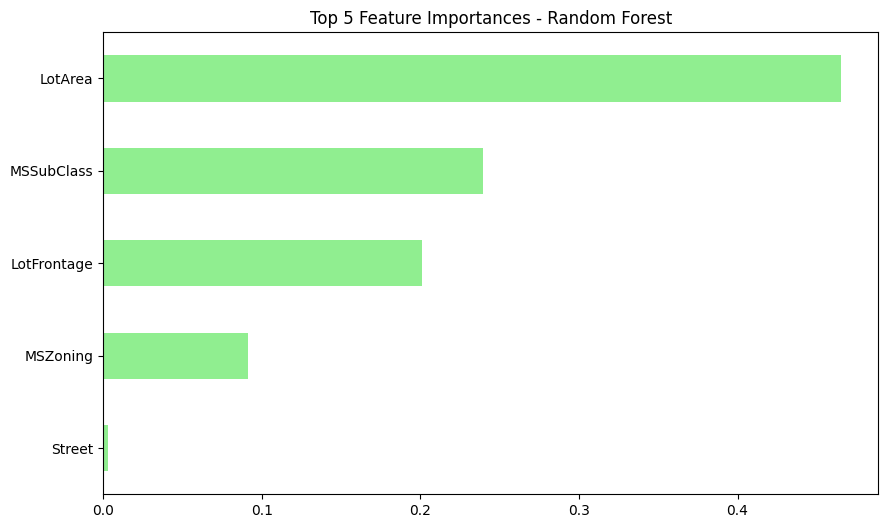

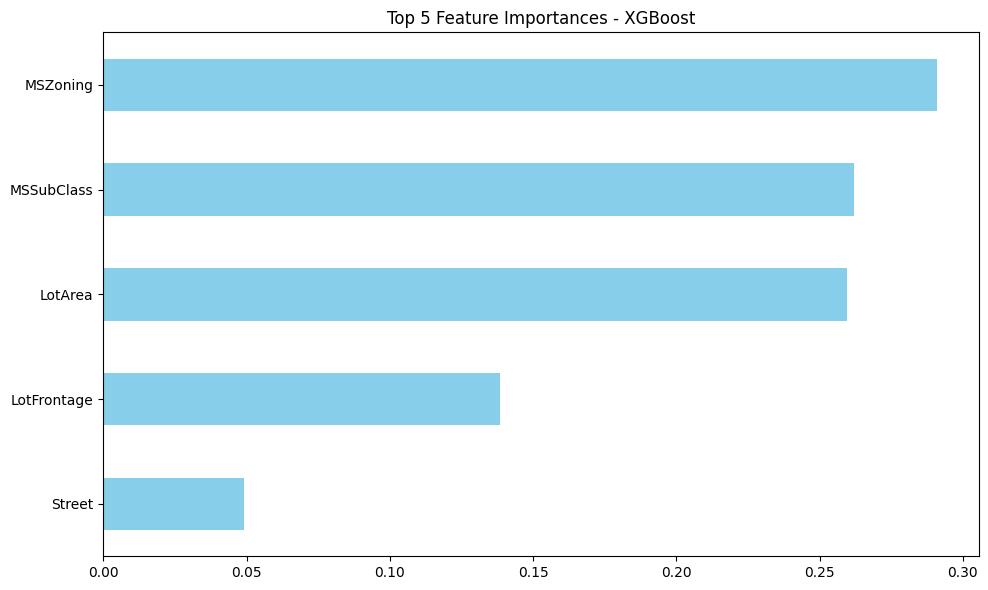

Top 5 Features - Random Forest:
LotArea        0.465540
MSSubClass     0.239191
LotFrontage    0.200938
MSZoning       0.091287
Street         0.003044
dtype: float64

Top 5 Features - XGBoost:
MSZoning       0.291042
MSSubClass     0.261921
LotArea        0.259440
LotFrontage    0.138414
Street         0.049183
dtype: float32


In [22]:
# Train the Random Forest model if not already trained
if 'Random Forest' not in trained_models:
    rf_model = RandomForestRegressor(**best_params_all['Random Forest'], random_state=42)
    rf_model.fit(X_train_selected, y_train)
    trained_models['Random Forest'] = rf_model

# Get feature importances from Random Forest
rf_importances = pd.Series(trained_models['Random Forest'].feature_importances_, index=X_train_selected.columns)
top_features_rf = rf_importances.sort_values(ascending=False).head(5)

# Plot feature importance for Random Forest
plt.figure(figsize=(10, 6))
top_features_rf.plot(kind='barh', color='lightgreen')
plt.title('Top 5 Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.show()

# Train the XGBoost model if not already trained
if 'XGBoost' not in trained_models:
    xgb_model = XGBRegressor(**best_params_all['XGBoost'], random_state=42)
    xgb_model.fit(X_train_selected, y_train)
    trained_models['XGBoost'] = xgb_model

# Get feature importances from XGBoost
xgb_importances = pd.Series(trained_models['XGBoost'].feature_importances_, index=X_train_selected.columns)
top_features_xgb = xgb_importances.sort_values(ascending=False).head(5)

# Plot feature importance for XGBoost
plt.figure(figsize=(10, 6))
top_features_xgb.plot(kind='barh', color='skyblue')
plt.title('Top 5 Feature Importances - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Display the top 5 features from both models
print("Top 5 Features - Random Forest:")
print(top_features_rf)

print("\nTop 5 Features - XGBoost:")
print(top_features_xgb)

In [26]:
# Ensure importances is defined
if 'importances' not in locals():
    if 'Random Forest' in trained_models and hasattr(trained_models['Random Forest'], 'feature_importances_'):
        model = trained_models['Random Forest']
        importances = pd.Series(model.feature_importances_, index=X_train_selected.columns)
    elif 'XGBoost' in trained_models and hasattr(trained_models['XGBoost'], 'feature_importances_'):
        model = trained_models['XGBoost']
        importances = pd.Series(model.feature_importances_, index=X_train.columns)
    else:
        raise NameError("Neither 'Random Forest' nor 'XGBoost' models are trained or available with feature importances.")

# Select top N features (e.g., top 5) based on feature importances
top_features = importances.nlargest(5).index.tolist()

# Filter the training and validation data
X_train_selected = X_train[top_features]
X_val_selected = X_val[top_features]

# Retrain models with the selected features
print("Model Comparison Results with Feature Selection:")
print("-" * 80)

for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_train_pred = model.predict(X_train_selected)
    y_val_pred = model.predict(X_val_selected)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    cv_rmse = -cross_val_score(model, X_train_selected, y_train, cv=3, scoring='neg_root_mean_squared_error')
    results.append({
        'Model': name,
        'Train RMSE': train_rmse,
        'Val RMSE': val_rmse,
        'Train MAE': train_mae,
        'Val MAE': val_mae,
        'Train R2': train_r2,
        'Val R2': val_r2,
        'CV RMSE': cv_rmse.mean(),
        'CV RMSE Std': cv_rmse.std()
    })
    trained_models[name] = model

# Convert results to a DataFrame and sort by Validation RMSE
results_df = pd.DataFrame(results).sort_values(by='Val RMSE')

print(results_df)

Model Comparison Results with Feature Selection:
--------------------------------------------------------------------------------
                Model  Train RMSE  Val RMSE  Train MAE   Val MAE  Train R2  \
15  Gradient Boosting    0.235340  0.256790   0.174579  0.195619  0.634620   
6   Gradient Boosting    0.235340  0.256790   0.174579  0.195619  0.634620   
7             XGBoost    0.199636  0.257545   0.146916  0.194896  0.737076   
16            XGBoost    0.199636  0.257545   0.146916  0.194896  0.737076   
14      Random Forest    0.162650  0.272047   0.121861  0.203112  0.825474   
5       Random Forest    0.162650  0.272047   0.121861  0.203112  0.825474   
4       Decision Tree    0.273549  0.281380   0.206943  0.208172  0.506346   
13      Decision Tree    0.273549  0.281380   0.206943  0.208172  0.506346   
8                 SVR    0.298418  0.289476   0.223629  0.215752  0.412505   
17                SVR    0.298418  0.289476   0.223629  0.215752  0.412505   
12        El

In [27]:
best_model_name = results_df.loc[results_df['CV RMSE'].idxmin(), 'Model']
print(f"The best model based on CV RMSE is: {best_model_name}")

The best model based on CV RMSE is: Gradient Boosting


In [28]:
import pickle
import os

# Get the best model based on Validation RMSE
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

# Save the best model to a .pkl file in the SML PROJECT folder
os.makedirs("SML PROJECT", exist_ok=True)
with open("SML PROJECT/best_model.pkl", "wb") as file:
    pickle.dump(best_model, file)

best_model_name = results_df.iloc[0]['Model']
print(f"✅ Best model '{best_model_name}' saved to 'model-training/best_model.pkl'")

✅ Best model 'Gradient Boosting' saved to 'model-training/best_model.pkl'


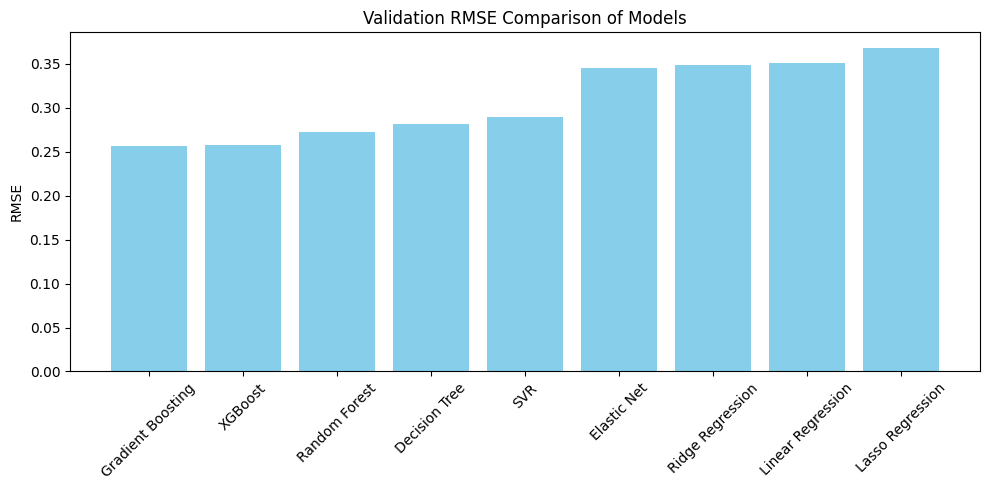


✅ Best Model based on Validation RMSE: Gradient Boosting


In [29]:
plt.figure(figsize=(10, 5))
plt.bar(results_df['Model'], results_df['Val RMSE'], color='skyblue')
plt.xticks(rotation=45)
plt.title('Validation RMSE Comparison of Models')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()
 
best_model_name = results_df.iloc[0]['Model']
print(f"\n✅ Best Model based on Validation RMSE: {best_model_name}")

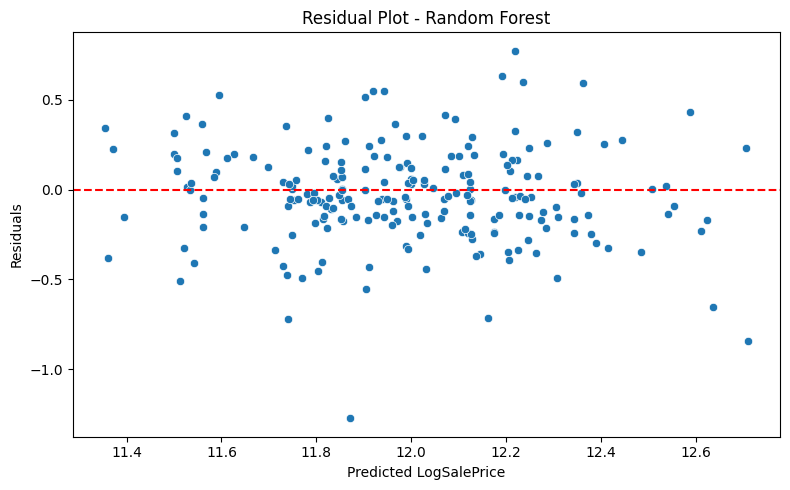

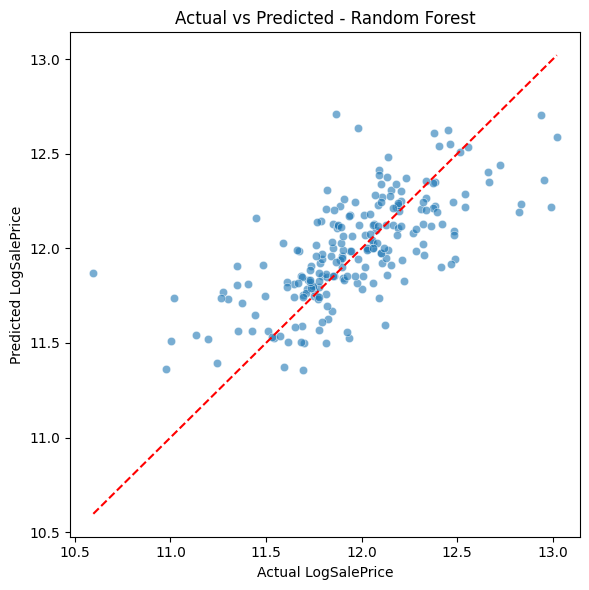

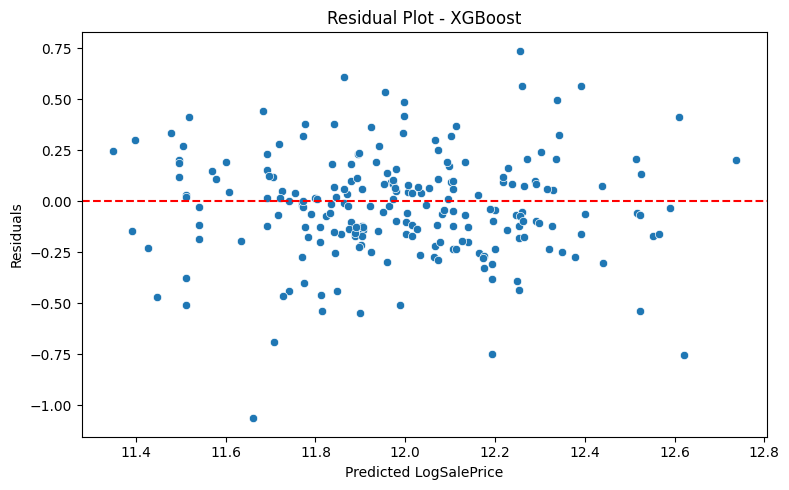

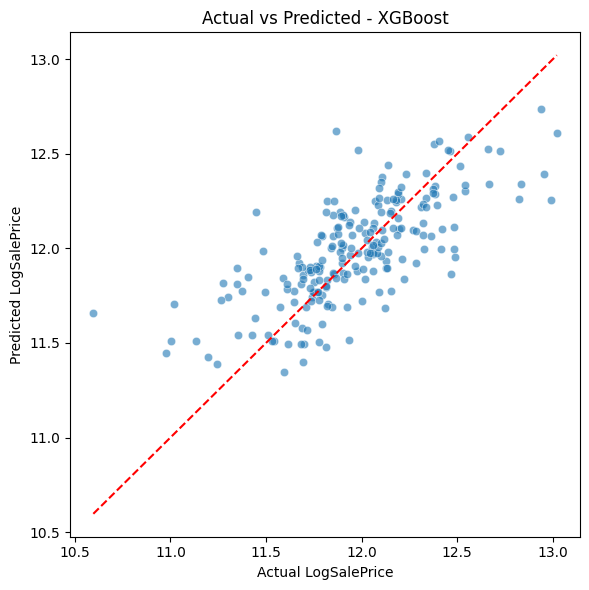

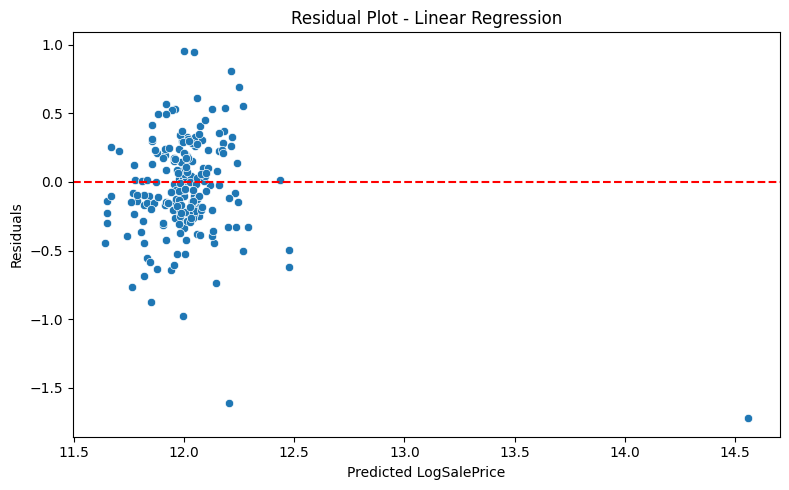

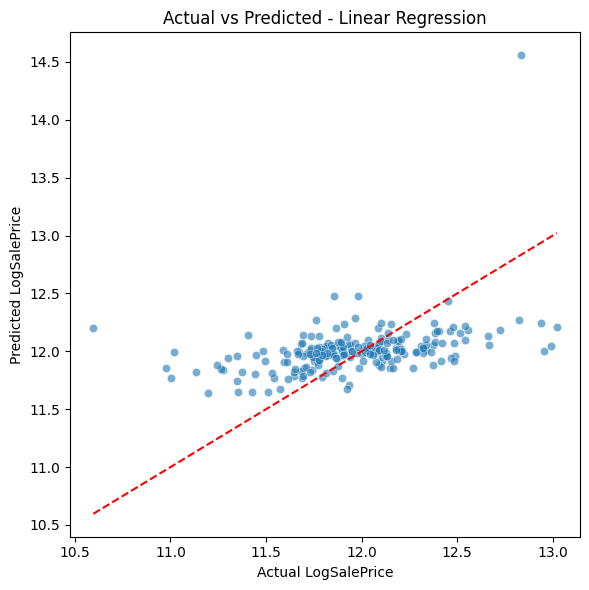

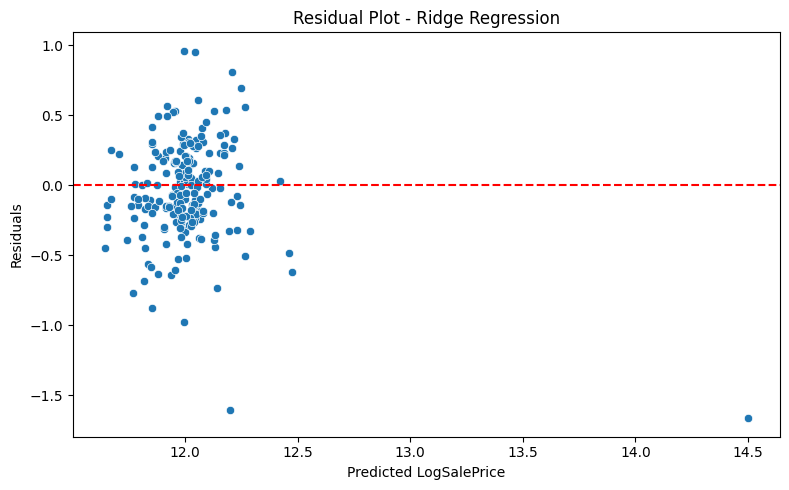

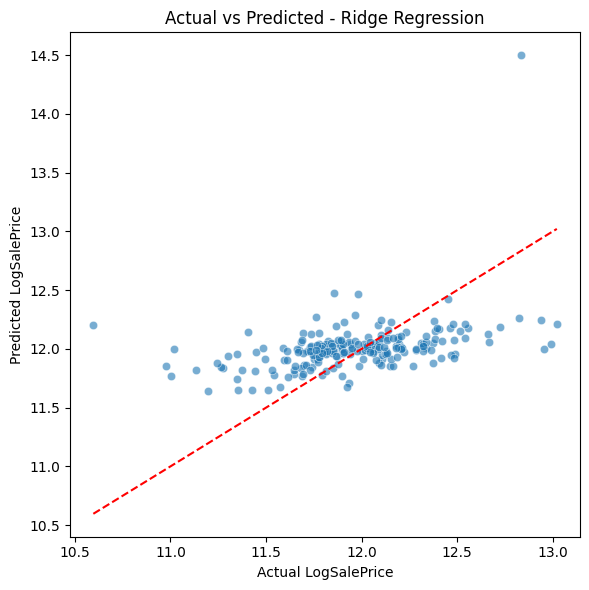

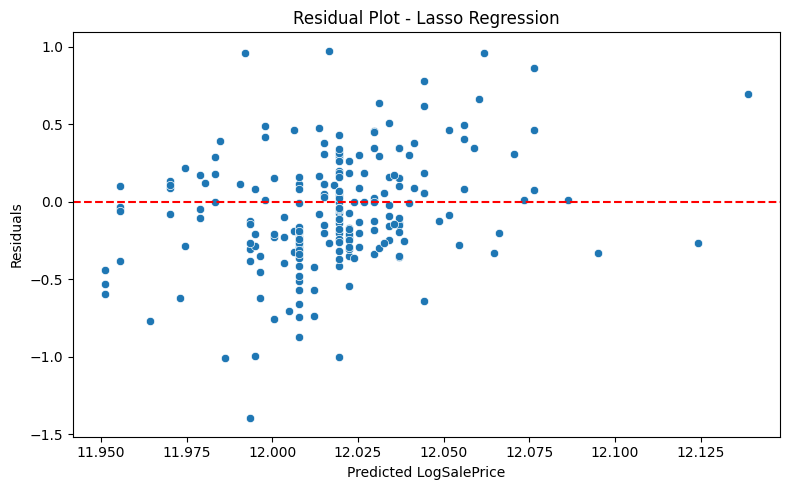

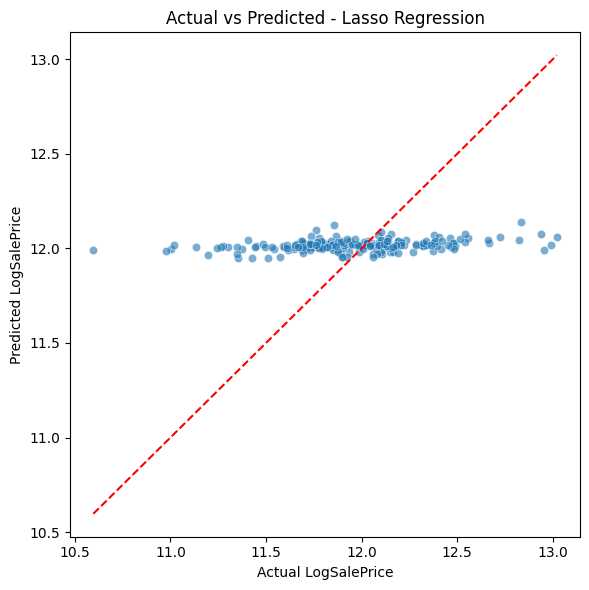

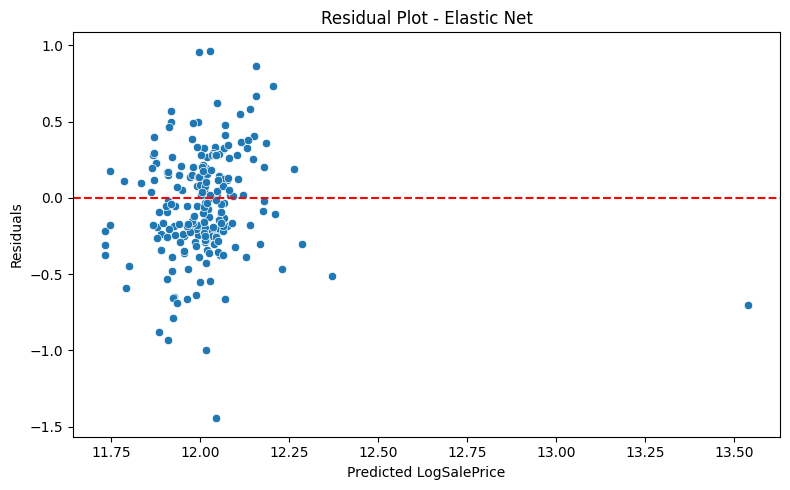

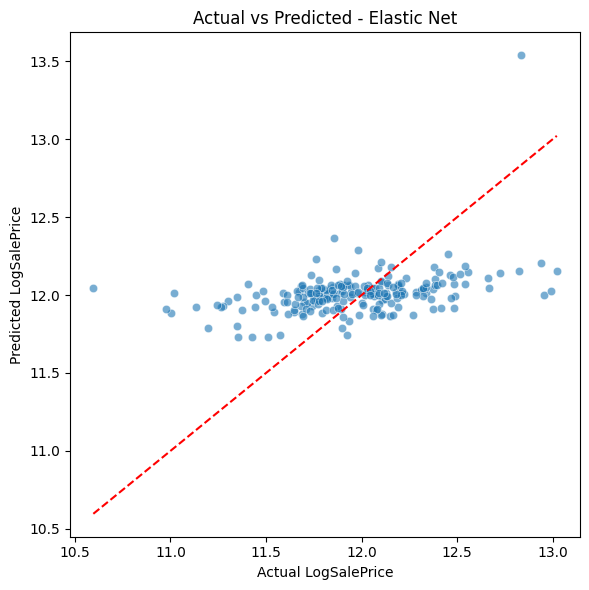

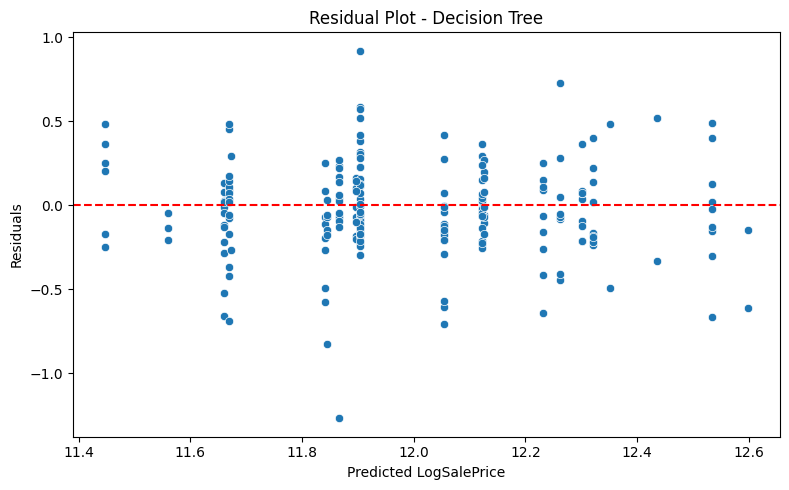

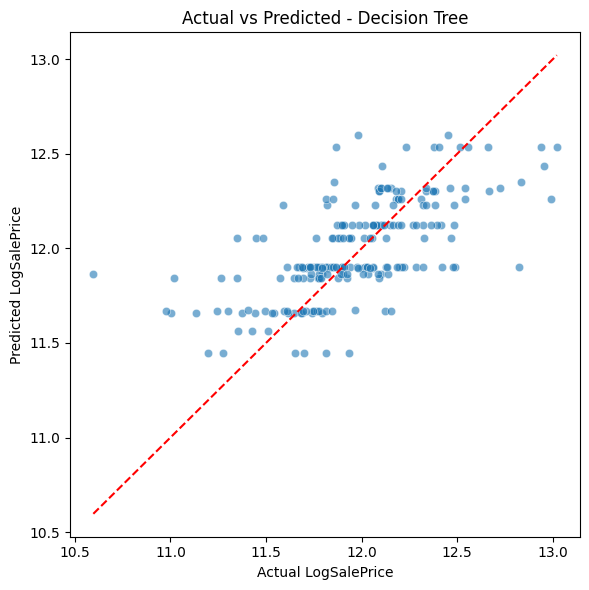

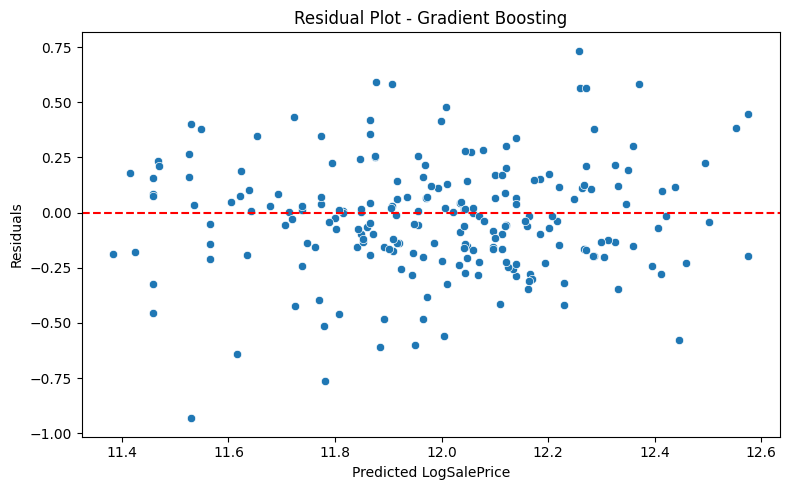

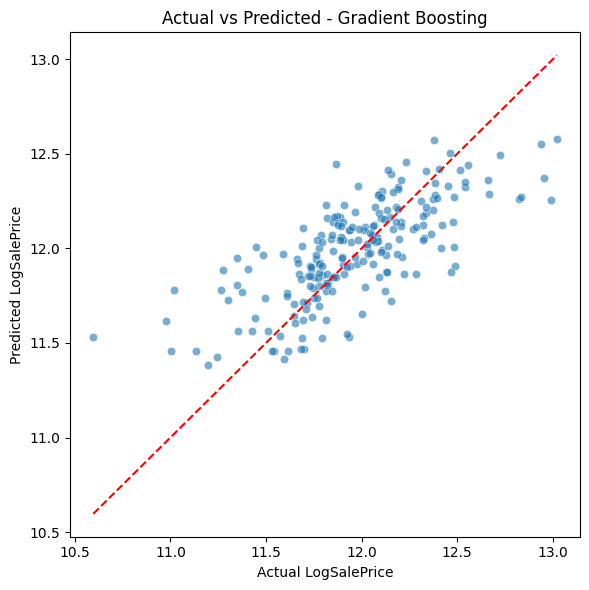

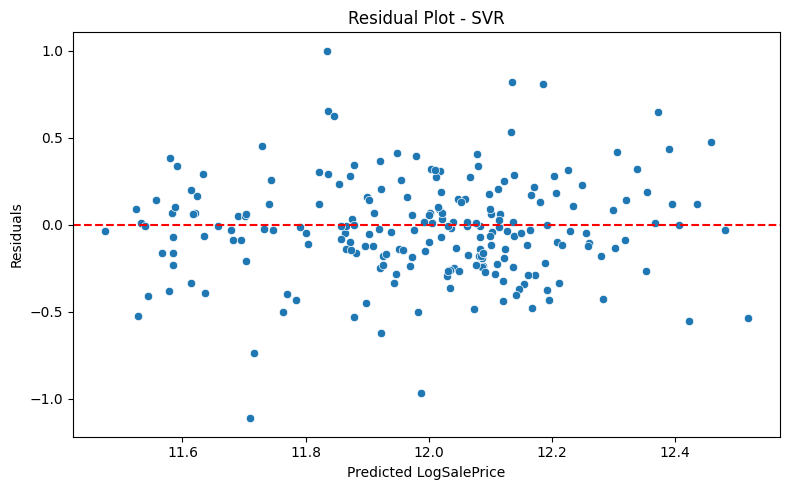

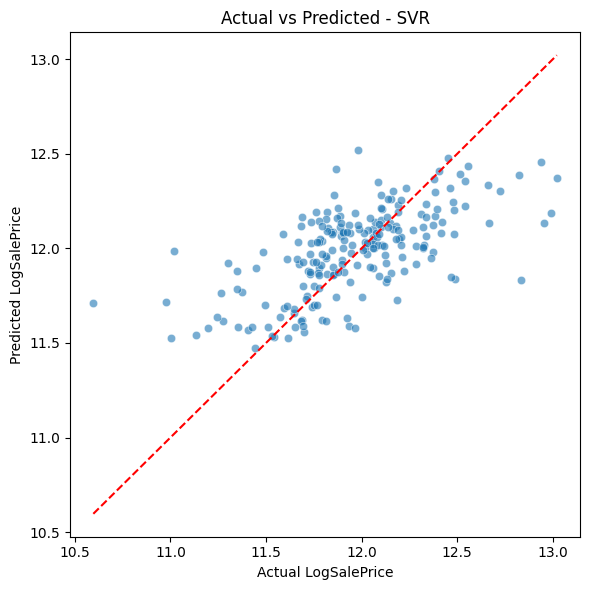

In [30]:
# Residual plots and Actual vs Predicted
for name, model in trained_models.items():
    y_val_pred = model.predict(X_val[X_train_selected.columns])
    residuals = y_val - y_val_pred
 
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_val_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residual Plot - {name}')
    plt.xlabel('Predicted LogSalePrice')
    plt.ylabel('Residuals')
    plt.tight_layout()
    plt.show()
 
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_val, y=y_val_pred, alpha=0.6)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--')
    plt.xlabel('Actual LogSalePrice')
    plt.ylabel('Predicted LogSalePrice')
    plt.title(f'Actual vs Predicted - {name}')
    plt.tight_layout()
    plt.show()